# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Problem Statement


The problem is to build a model that predicts whether a customer will respond to an offer. 
The following is the strategy to solve this problem:
1. Combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. 

2. Assess the accuracy and F1-score of a naive model that assumes all offers were successful. This provides a baseline for evaluating the performance of models. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. We chose the F1-score metric because it is "a weighted average of the precision and recall metrics". 

3. Compare the performance of logistic regression, random forest, and gradient boosting models. 

4. Fine-Tune parameters of the model that has the highest accuracy and F1-score.

# Data Cleaning

- Perform Exploratory Data Analysis (EDA)
- Combine offer portfolio, customer demographic, and transaction data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from CleanData import clean_portfolio, clean_profile, convert_to_datetime
from CleanData import clean_transcript, create_offeranalysis_dataset
from exploratory_data_analysis import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



# Offer portfolio Exploratory Data Analysis (EDA)

- Offer record attributes
        id (string) - Offer id
        offer_type (string) - String that describes the offer type
            bogo (Buy One Get One Free)
            discount
            informational
        difficulty (int) - Minimum amount a customer must spend to complete an offer
        reward (int) - Reward given for completing an offer
        duration (int) - Offer duration [days]
        channels (list of strings)
- EDA conclusions
        Channels variable is multi-label (can split using MultiLabelBinarizer)
        Need to rename 'id' variable to 'offerid'
        Need to One Hot Encode (OHE) 'offer_type' variable



In [3]:
# Print the offer portfolio data
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


# Clean the offer portfolio data

    1. Change the name of the 'id' column to 'offerid'
    2. Change the name of the 'duration' column to 'durationdays'
    3. Remove underscores from column names
    4. One hot encode the 'offertype' column
    5. One hot encode the 'channels' columns
    6. Replace the 'offertype' and 'channels' columns with their respective one hot encoded values



In [4]:
portfolio = clean_portfolio()
portfolio

,offerid,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


# Customer profile data EDA

- Customer profile record attributes
        age (int) - Customer age
        became_member_on (int) - Date when customer created an app account
        gender (str) - Customer gender (note some entries contain 'O' for other rather than M or F)
        id (str) - Customer id
        income (float) - Customer's income
- Customer profile EDA conclusions
        Gender and income have ~ 13% missing data
            Age is 118 when income is NaN
        Gender is not specified for ~ 1.5% of the data
        Year that a customer became a rewards member is not uniformly distributed - potential customer differentiator
        Month that a customer became a rewards member is approximately uniformly distributed - probably not a useful feature to include



In [5]:
# View customer profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
# Find missing values
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

In [7]:
# customer gender attribute distribution
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [8]:
# Summary customer profile attribute statistics when customer income is not specified
profile[profile['income'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [9]:
# Summary customer profile attribute statistics when customer income is specified
profile[profile['income'].notnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [10]:
# What year a customer became a rewards member
became_member_on = profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

In [11]:
# month a customer became a rewards member
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

# Clean the customer profile data

    1. Remove customers with missing income data
    2. Remove customer profiles where the gender attribute is missing
    3. Change the name of the 'id' column to 'customerid'
    4. Transform the 'became_member_on' column to a datetime object
    5. One hot encode a customer's membership start year
    6. One hot encode a customer's age range
    7. Transform a customer's gender from a character to a number



In [12]:
(profile,
 gender_integer_map) = clean_profile()

print("Number of user profiles: %d" % (profile.shape[0]))

Number of user profiles: 14613


In [13]:
# View profile
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [14]:
# Print the mapping of customer gender string to an integer value
print(gender_integer_map)

{'F': 0, 'M': 1}



# Plot Income Distribution as a Function of Gender

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


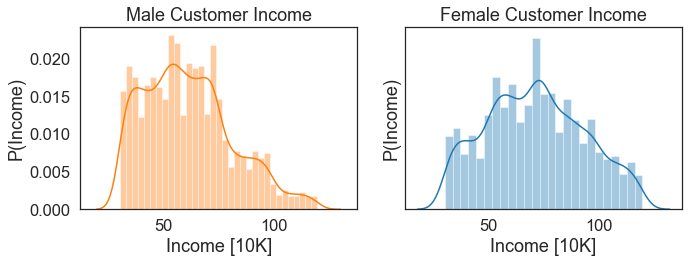

In [15]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

### Observation
Plot Income Distribution as a Function of Gender
Results suggest that the minimum and maximum income for both male and female customers is approximately the same. 
However, male customer income is slightly biased towards lower values compared to female customer income.

# Evaluate Membership Start Year Statistics

Text(0,0.5,'Count')

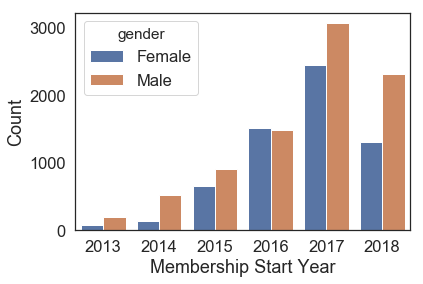

In [16]:
membership_date = initialize_membership_date(profile,
                                             gender_integer_map)

sns.barplot(x='startyear', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')


### Observation
The results suggest that most customers recently joined the Starbucks rewards program. These results also suggest that there are more male customers than female customers.

In [17]:
# Compute customer gender distribution
membership_date.groupby('gender')['count'].sum()

gender
Female    6129
Male      8484
Name: count, dtype: int64

# Evaluate Age Range Statistics

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

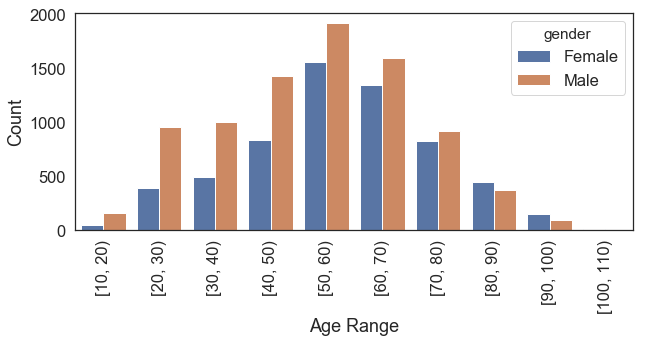

In [18]:
age_range = init_agerange(profile,
                          gender_integer_map)

plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

**Observation:** average customer age is between 50 and 60 years old.

# Transaction data EDA

- Customer transaction record attributes
        event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)
        person (str) - Customer id
        time (int) - Time in hours. The data begins at time t=0
        value - (dict of strings) - Either an offer id or transaction amount depending on the record
- Customer transaction data EDA conclusions
        Need to separate offer and customer purchase data
        Results suggest ~ 45 % of the events are customers purchases and ~ 55% of the events describe customer offers

In [19]:
# View Transaction Data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
# event type distribution
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [21]:
# percentage of customer transaction and offer events
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


# Clean the transaction data

    1. Change the name of the 'person' column to 'customerid'
    2. Remove customer id's that are not in the customer profile DataFrame
    3. Convert time variable units from hours to days
    4. Change the name of the 'time' column to 'timedays'
    5. Create a DataFrame that describes offers
       - Create an offerid column
       - Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
       - One hot encode customer offer events
    6. Create a DataFrame that describes customer transaction events
       - Parse customer transaction values



In [22]:
offer_data, transaction = clean_transcript(profile)

Percentage of transactions removed: 12.31 %


In [23]:
# transformed customer offer data
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


In [24]:
# transformed customer transaction data
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


# Combine transaction, demographic and offer data

For each customer, apply the following:

    1. Select a customer's profile
    2. Select offer data for a specific customer
    3. Select transactions for a specific customer
    4. Initialize DataFrames that describe when a customer receives, views, and completes an offer
    5. Iterate over each offer a customer receives
        - Initialize the current offer id
        - Look-up a description of the current offer
        - Initialize the time period when an offer is valid
        - Initialize a Boolean array that select customer transactions that fall within the valid offer time window
        - Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)
        - Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
        - Determine whether the current offer was successful
            - For an offer to be successful a customer has to view and complete it
        - Select customer transactions that occurred within the current offer valid time window
        - Initialize a dictionary that describes the current customer offer
        - Update a list of dictionaries that describes the effectiveness of offers to a specific customer

In [25]:
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              offer_data,
                                              transaction)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

 [Elapsed Time: 0:16:30] |##################################| (Time:  0:16:30) 


,offerid,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


In [26]:
# Split the data into training and testing data
random_state = 2310

class_label_name = 'offersuccessful'

variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [27]:
# Print offer effectiveness data attributes
print(variable_names)

Index([  'difficulty', 'durationdays',       'reward',         'bogo',
           'discount',       'mobile',       'social',          'web',
             'gender',       'income',           2013,           2014,
                 2015,           2016,           2017,           2018,
           '[10, 20)',     '[20, 30)',     '[30, 40)',     '[40, 50)',
           '[50, 60)',     '[60, 70)',     '[70, 80)',     '[80, 90)',
          '[90, 100)',   '[100, 110)'],
      dtype='object')


In [28]:
# Initialize a DataFrame that describes the training data 
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid,
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=['difficulty',
                                            'durationdays',
                                            'reward',
                                            'bogo',
                                            'discount',
                                            'mobile',
                                            'social',
                                            'web'])

training_data.head()

,offerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,47000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,5a8bc65990b245e5a138643cd4eb9837,1.0,61000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,51000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,44000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,35000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Analyze Offer Statistics

In [29]:
percent_success = initialize_percent_success(portfolio,
                                             training_data)
percent_success

,offerid,count,percentsuccess,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,5236,75.534759,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5262,72.671988,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,5257,60.871219,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,5302,54.149378,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5152,51.339286,10,5,10,1,0,0,1,1,1,1
5,2906b810c7d4411798c6938adc9daaa5,5203,48.337498,10,7,2,0,1,0,1,1,0,1
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5280,48.314394,5,7,5,1,0,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5313,46.019198,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,5229,7.879136,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,5234,6.285823,0,3,0,0,0,1,1,1,1,0


**Observation:** These results suggest that distribution of offers in the simulated Starbucks mobile application data is approximately uniform. They also imply that the percentage of an offer's success ranges from ~ 6% to 75%, with the two least successful offers being informational.

## Generate a plot that illustrates:

    - How many customers were provided a specific offer
    - Offer sucess rate (percentsuccess)

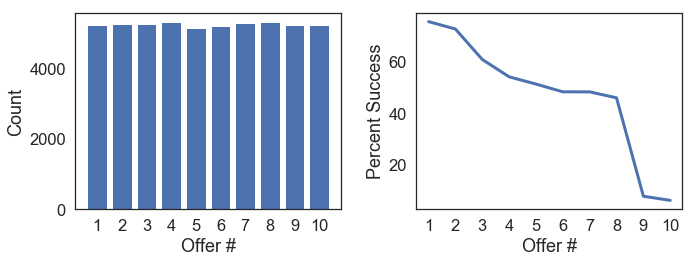

In [30]:
f, ax = plt.subplots(figsize=(10, 4),
                     nrows=1,
                     ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer #')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1,
           percent_success['percentsuccess'],
           linewidth=3)
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer #')
ax[1].set_ylabel('Percent Success')
plt.tight_layout()

# Transform variables

In [31]:
variables_to_scale = ['difficulty', 'durationdays', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values =\
        min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values =\
        min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

## Analyze Customer Statistics

- General trends

    Offer success increases with average customer income and age
    For unsuccessful offers the percentage of male customers is typically significantly higher than the percentage of     female customers
    Offers are less successful for customers who created an account on the Starbucks rewards mobile application in       2018 (membership start year)
    

- Offer successful
        Average customer income: 65902.5
        Average customer age: 55.7 years
        Percentage of male customers: 55.1%
        Percentage of female customers: 44.9%
        Earlier membership start year more likely

- Offer unsuccessful
        Average customer income: 58136.2
        Average customer age: 52.6 years
        Percentage of male customers: 69.8%
        Percentage of female customers: 30.2%
        Later membership start year more likely

offerid: fafdcd668e3743c1bb461111dcafc2a4
Offer successful
	Average customer income: $65920.0
	Average customer age: 55.8 [years]
Offer unsuccessful
	Average customer income: $57199.4
	Average customer age: 52.5 [years]
   gender  percentage successful
0    Male   55.271808        Yes
1  Female   44.728192        Yes
2    Male   70.569867         No
3  Female   29.430133         No
    membershipstartyear  percentage successful
0                  2013    2.174463        Yes
6                  2013    0.546448         No
1                  2014    5.638432        Yes
7                  2014    2.419984         No
2                  2015   13.527181        Yes
8                  2015    2.029664         No
3                  2016   25.764855        Yes
9                  2016    2.810304         No
4                  2017   36.106195        Yes
10                 2017   40.124902         No
5                  2018   16.788875        Yes
11                 2018   52.068696         No


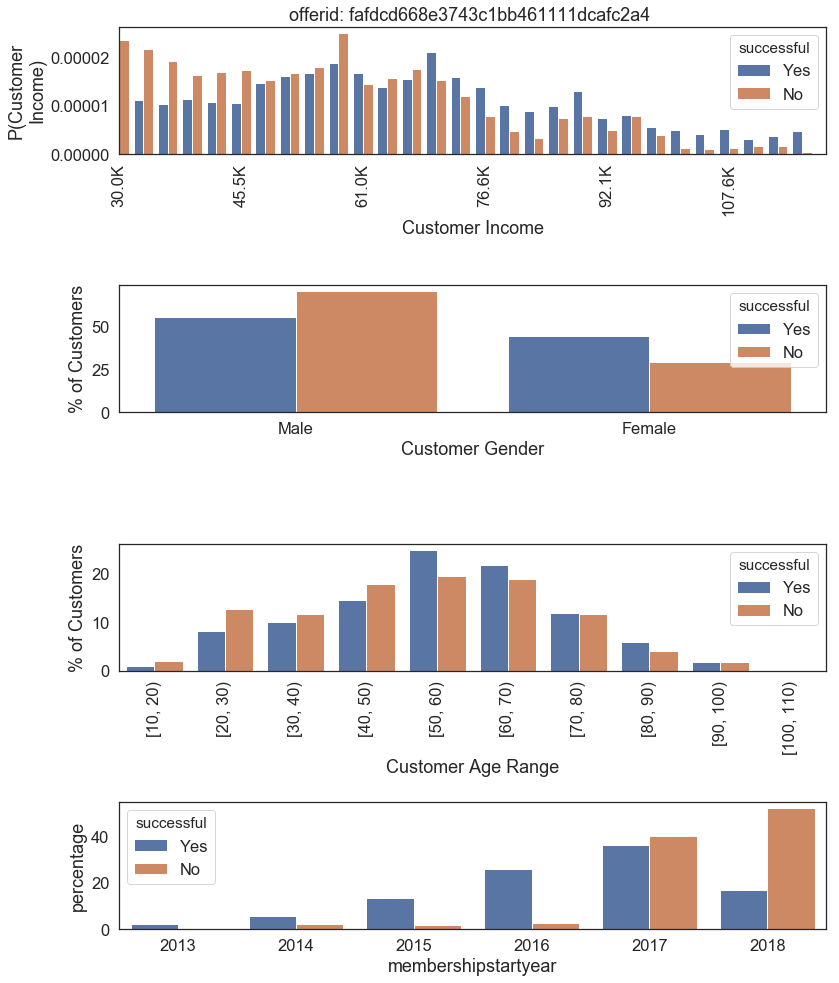

In [32]:
explore_customer_offer(0, percent_success, training_data, gender_integer_map)

offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2
Offer successful
	Average customer income: $65465.7
	Average customer age: 55.3 [years]
Offer unsuccessful
	Average customer income: $59251.8
	Average customer age: 53.4 [years]
   gender  percentage successful
0    Male   54.837866        Yes
1  Female   45.162134        Yes
2    Male   70.792768         No
3  Female   29.207232         No
    membershipstartyear  percentage successful
0                  2013    2.092050        Yes
6                  2013    0.695410         No
1                  2014    5.020921        Yes
7                  2014    2.712100         No
2                  2015   12.186192        Yes
8                  2015    3.616134         No
3                  2016   26.307531        Yes
9                  2016    4.450626         No
4                  2017   37.578452        Yes
10                 2017   41.237830         No
5                  2018   16.814854        Yes
11                 2018   47.287900         No


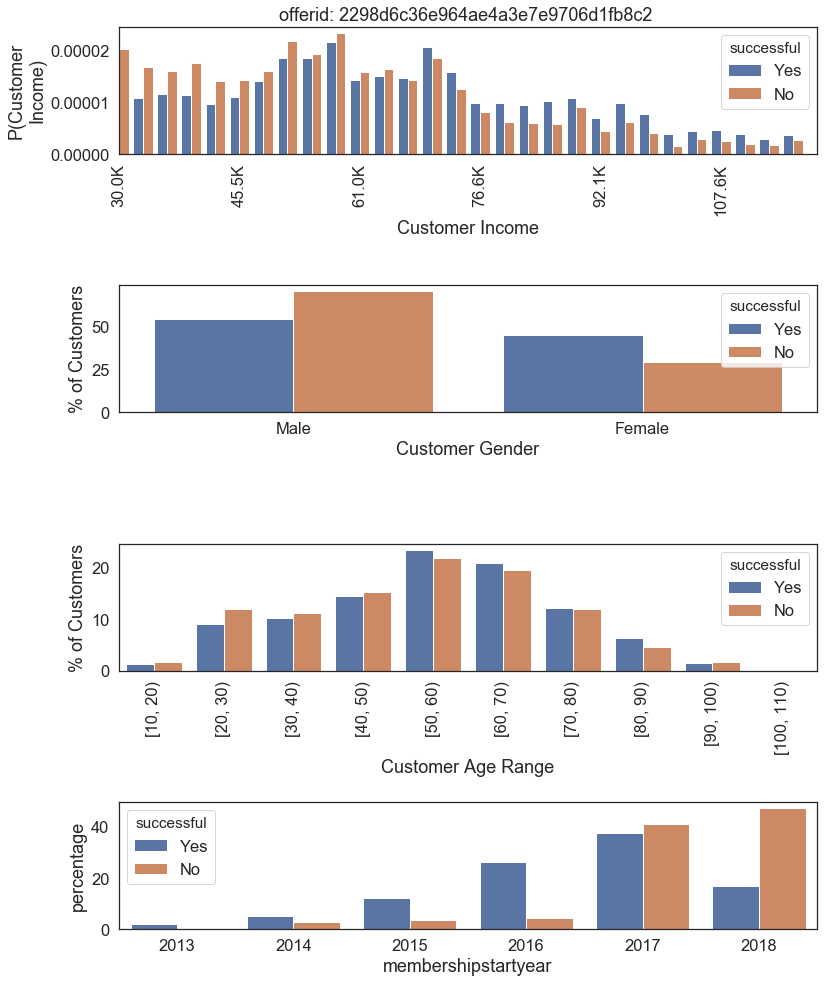

In [33]:
# Explore another customer 
explore_customer_offer(1, percent_success, training_data, gender_integer_map)

offerid: f19421c1d4aa40978ebb69ca19b0e20d
Offer successful
	Average customer income: $67004.7
	Average customer age: 56.3 [years]
Offer unsuccessful
	Average customer income: $59091.2
	Average customer age: 53.2 [years]
   gender  percentage successful
0    Male   53.187500        Yes
1  Female   46.812500        Yes
2    Male   66.699076         No
3  Female   33.300924         No
    membershipstartyear  percentage successful
0                  2013    1.687500        Yes
6                  2013    1.847351         No
1                  2014    4.500000        Yes
7                  2014    4.666991         No
2                  2015   12.593750        Yes
8                  2015    6.514341         No
3                  2016   27.968750        Yes
9                  2016    7.924161         No
4                  2017   38.156250        Yes
10                 2017   40.398639         No
5                  2018   15.093750        Yes
11                 2018   38.648517         No


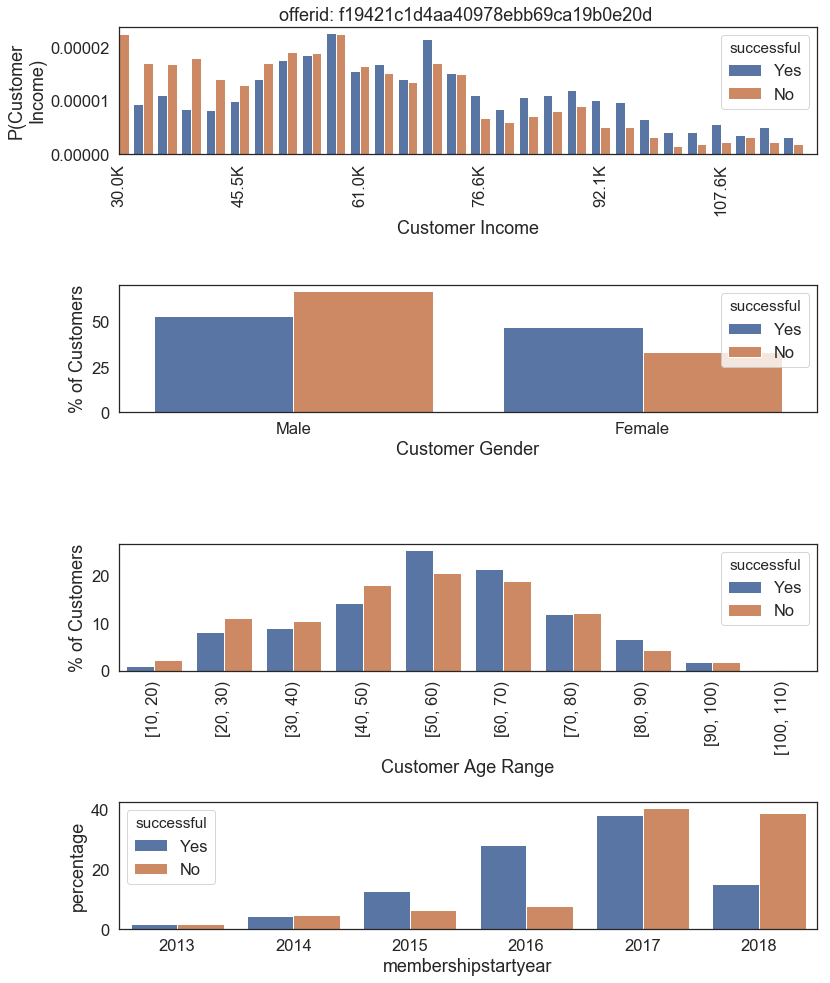

In [34]:
# Explore another customer
explore_customer_offer(2, percent_success, training_data, gender_integer_map)

offerid: ae264e3637204a6fb9bb56bc8210ddfd
Offer successful
	Average customer income: $68546.1
	Average customer age: 56.4 [years]
Offer unsuccessful
	Average customer income: $59146.4
	Average customer age: 52.9 [years]
   gender  percentage successful
0    Male    50.81853        Yes
1  Female    49.18147        Yes
2    Male    67.46195         No
3  Female    32.53805         No
    membershipstartyear  percentage successful
0                  2013    1.462905        Yes
6                  2013    3.167421         No
1                  2014    3.065134        Yes
7                  2014    5.882353         No
2                  2015   13.409962        Yes
8                  2015    8.062526         No
3                  2016   28.247997        Yes
9                  2016   11.065405         No
4                  2017   37.478231        Yes
10                 2017   37.967914         No
5                  2018   16.335772        Yes
11                 2018   33.854381         No


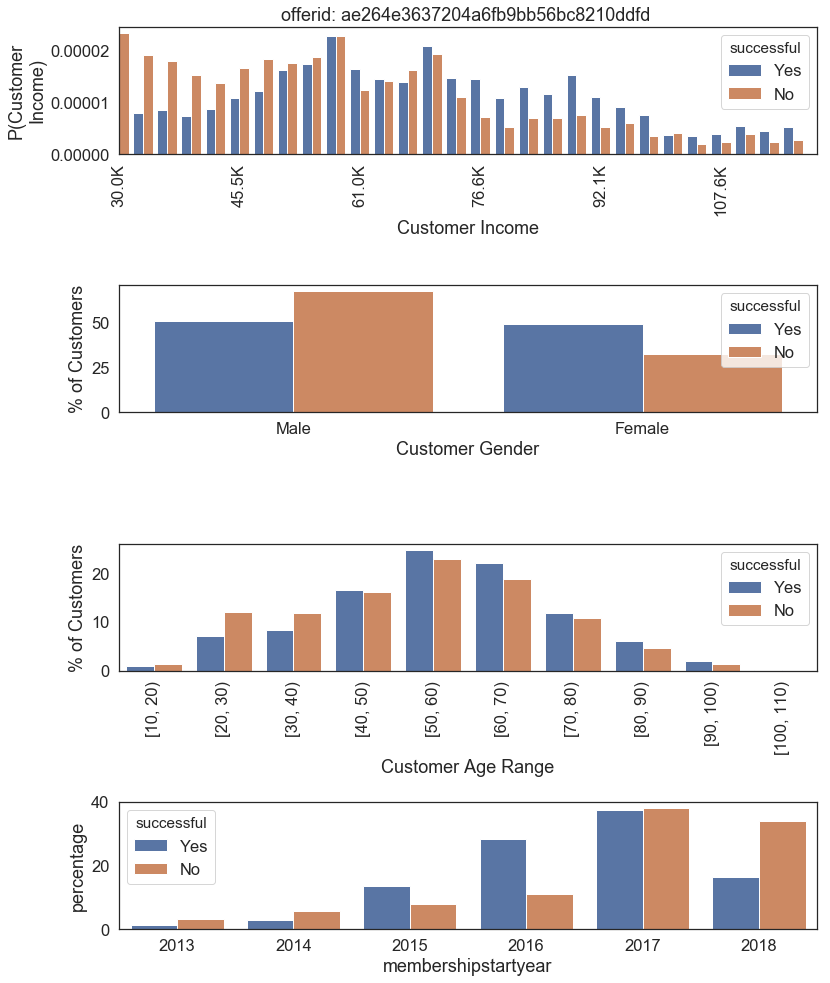

In [35]:
explore_customer_offer(3, percent_success, training_data, gender_integer_map)

offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0
Offer successful
	Average customer income: $69680.7
	Average customer age: 56.9 [years]
Offer unsuccessful
	Average customer income: $57589.4
	Average customer age: 52.1 [years]
   gender  percentage successful
0  Female   51.417769        Yes
1    Male   48.582231        Yes
2    Male   68.607898         No
3  Female   31.392102         No
    membershipstartyear  percentage successful
0                  2013    1.285444        Yes
6                  2013    2.353410         No
1                  2014    3.251418        Yes
7                  2014    6.501795         No
2                  2015   13.119093        Yes
8                  2015    7.259673         No
3                  2016   28.241966        Yes
9                  2016   10.929398         No
4                  2017   40.037807        Yes
10                 2017   37.654567         No
5                  2018   14.064272        Yes
11                 2018   35.301157         No


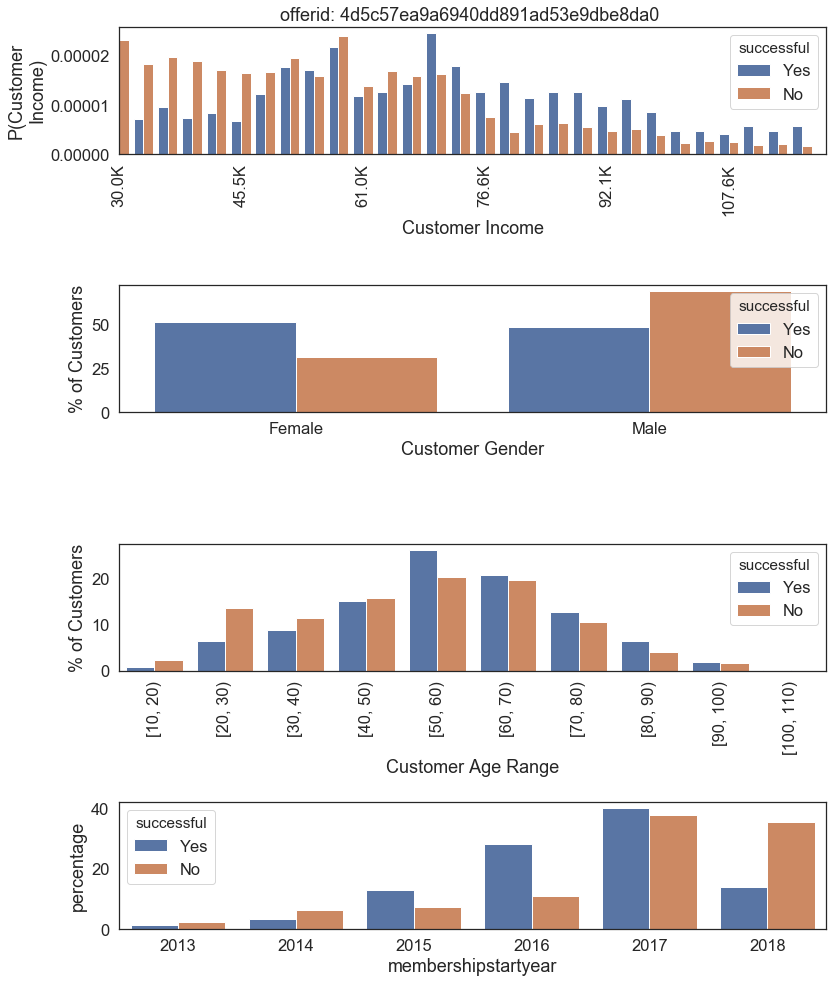

In [36]:
explore_customer_offer(4, percent_success, training_data, gender_integer_map)


offerid: 2906b810c7d4411798c6938adc9daaa5
Offer successful
	Average customer income: $67443.8
	Average customer age: 56.1 [years]
Offer unsuccessful
	Average customer income: $60602.7
	Average customer age: 53.1 [years]
   gender  percentage successful
0    Male   54.433400        Yes
1  Female   45.566600        Yes
2    Male   62.462798         No
3  Female   37.537202         No
    membershipstartyear  percentage successful
0                  2013    2.107356        Yes
6                  2013    1.525298         No
1                  2014    4.970179        Yes
7                  2014    3.683036         No
2                  2015   13.161034        Yes
8                  2015    9.709821         No
3                  2016   28.190855        Yes
9                  2016   14.360119         No
4                  2017   35.944334        Yes
10                 2017   37.537202         No
5                  2018   15.626243        Yes
11                 2018   33.184524         No


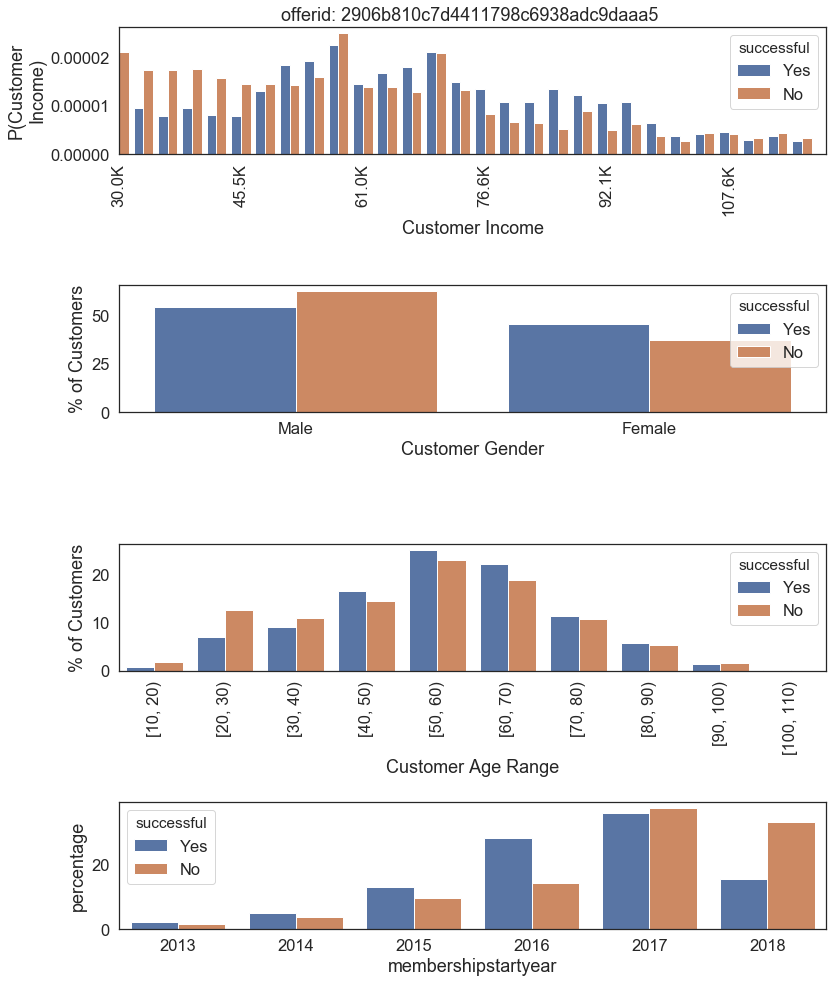

In [37]:
explore_customer_offer(5, percent_success, training_data, gender_integer_map)

offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer successful
	Average customer income: $66352.1
	Average customer age: 55.9 [years]
Offer unsuccessful
	Average customer income: $60820.7
	Average customer age: 54.1 [years]
   gender  percentage successful
0    Male   52.881223        Yes
1  Female   47.118777        Yes
2    Male   63.613045         No
3  Female   36.386955         No
    membershipstartyear  percentage successful
0                  2013    2.116817        Yes
6                  2013    1.758886         No
1                  2014    3.841631        Yes
7                  2014    4.213998         No
2                  2015   14.582517        Yes
8                  2015    9.160865         No
3                  2016   25.127401        Yes
9                  2016   14.950531         No
4                  2017   36.377891        Yes
10                 2017   38.622206         No
5                  2018   17.953744        Yes
11                 2018   31.293514         No


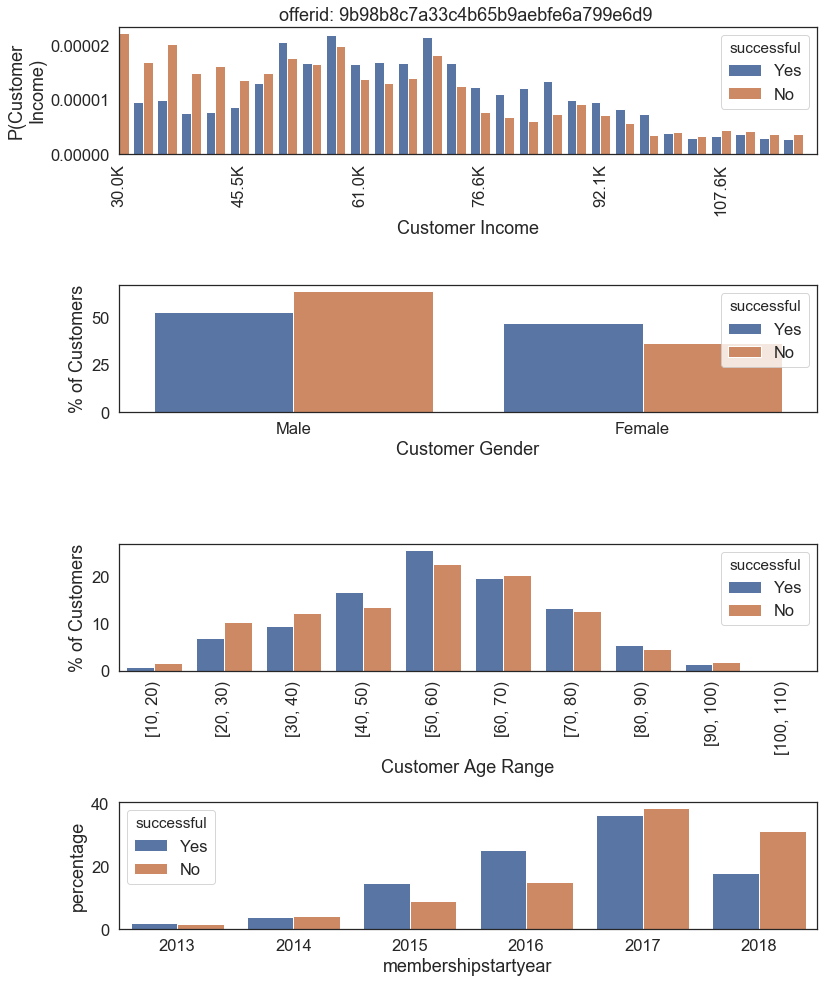

In [38]:
explore_customer_offer(6, percent_success, training_data, gender_integer_map)


offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7
Offer successful
	Average customer income: $67925.5
	Average customer age: 56.1 [years]
Offer unsuccessful
	Average customer income: $60292.2
	Average customer age: 53.6 [years]
   gender  percentage successful
0    Male   52.392638        Yes
1  Female   47.607362        Yes
2    Male   62.622036         No
3  Female   37.377964         No
    membershipstartyear  percentage successful
0                  2013    1.472393        Yes
6                  2013    2.022315         No
1                  2014    4.335378        Yes
7                  2014    4.672245         No
2                  2015   12.842536        Yes
8                  2015    9.414226         No
3                  2016   28.670757        Yes
9                  2016   14.365411         No
4                  2017   35.664622        Yes
10                 2017   37.343096         No
5                  2018   17.014315        Yes
11                 2018   32.182706         No


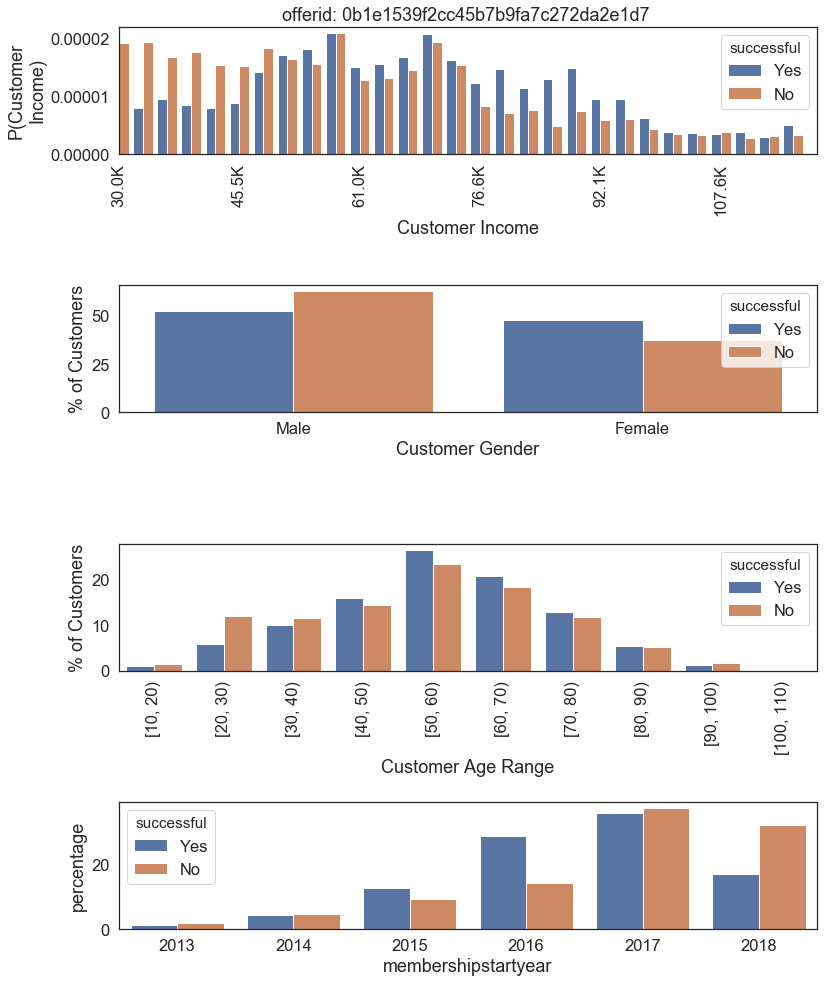

In [39]:
explore_customer_offer(7, percent_success, training_data, gender_integer_map)


offerid: 3f207df678b143eea3cee63160fa8bed
Offer successful
	Average customer income: $68996.5
	Average customer age: 58.2 [years]
Offer unsuccessful
	Average customer income: $63204.4
	Average customer age: 54.8 [years]
   gender  percentage successful
0    Male   53.155340        Yes
1  Female   46.844660        Yes
2    Male   58.418103         No
3  Female   41.581897         No
    membershipstartyear  percentage successful
0                  2013    1.699029        Yes
6                  2013    1.930662         No
1                  2014    5.339806        Yes
7                  2014    4.608678         No
2                  2015   13.106796        Yes
8                  2015    9.860909         No
3                  2016   25.728155        Yes
9                  2016   19.991696         No
4                  2017   36.650485        Yes
10                 2017   37.782852         No
5                  2018   17.475728        Yes
11                 2018   25.825202         No


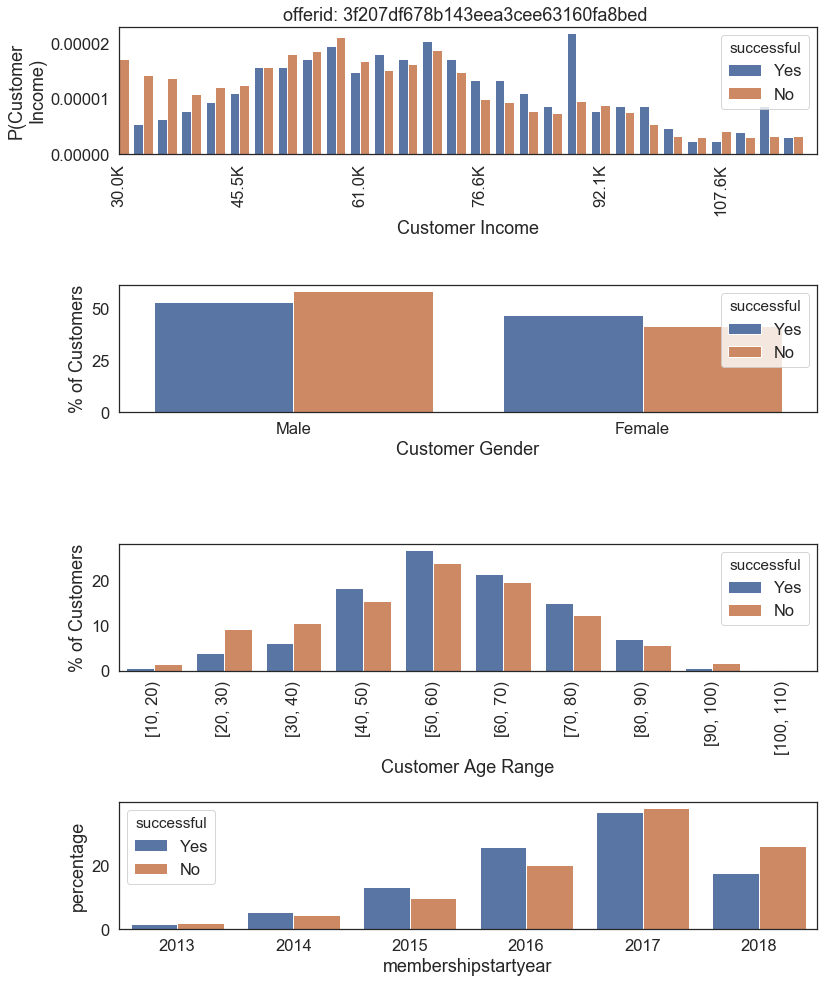

In [40]:
explore_customer_offer(8, percent_success, training_data, gender_integer_map)


offerid: 5a8bc65990b245e5a138643cd4eb9837
Offer successful
	Average customer income: $63902.1
	Average customer age: 56.3 [years]
Offer unsuccessful
	Average customer income: $63948.1
	Average customer age: 54.9 [years]
   gender  percentage successful
0    Male   56.838906        Yes
1  Female   43.161094        Yes
2    Male   57.594292         No
3  Female   42.405708         No
    membershipstartyear  percentage successful
0                  2013    2.431611        Yes
6                  2013    1.610601         No
1                  2014    6.686930        Yes
7                  2014    4.097859         No
2                  2015   11.854103        Yes
8                  2015   10.805301         No
3                  2016   24.316109        Yes
9                  2016   19.816514         No
4                  2017   37.689970        Yes
10                 2017   39.123344         No
5                  2018   17.021277        Yes
11                 2018   24.546381         No


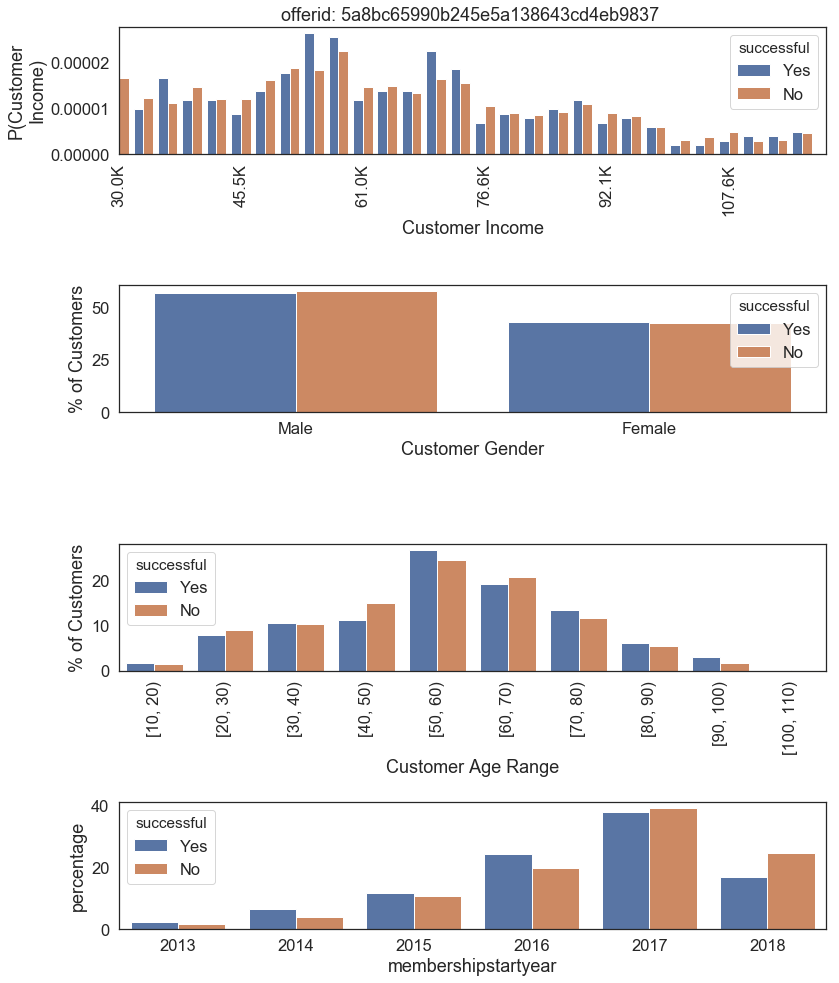

In [41]:
explore_customer_offer(9, percent_success, training_data, gender_integer_map)


# Predictive Modeling

## Evaluate naive predictor performance

In [42]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))


Naive predictor accuracy: 0.472
Naive predictor f1-score: 0.641


## Logistic Regression model

In [43]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  11.7s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   0.3s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  12.4s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   0.3s
[CV] ................................ penalty=l1, C=1.0, total=  12.6s
[CV] penalty=l1, C=0.1 ...............................................
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   17.4s finished


In [47]:
# model performance evaluation function
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [48]:
# Evaluate Logistic Regression Model Performance
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.716


(0.7215255012579096, 0.7163077878958508)

## Random Forest Model

In [49]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.2s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.2s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.2s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=6 
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=6 
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=6 
[CV]  n_estimators=30, min_samples_sp

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   38.6s


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=   6.9s
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=   6.9s
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, total=   6.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.6s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.7s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  n_estimators=300, min_samples_split=2, min_sam

[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   2.8s
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   2.8s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   0.6s
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   0.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_f

[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, total=  10.9s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, total=  11.0s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=8 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=8 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=3, total=   3.3s
[CV] n_estimators=100, min_samples_split=10, min_samp

[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   0.4s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.2min


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, total=   6.5s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, total=   6.5s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, total=   6.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   3.2s
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   3.3s
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=6, total=   3.3s
[CV] n_estimators=200, min_samples_split=2,

[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   4.3s
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=4, total=   4.3s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9, total=   5.6s
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9, total=   5.6s
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=9, total=   5.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV] n_estimators=100, min_samples_split=10, min_samples_l

[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, total=   5.9s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.6s
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.6s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.6s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_featu

[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   3.1s
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   3.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   3.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_dep

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  6.1min finished


In [50]:
# Evalaute Random Forest Model Performance
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.741
RandomForestClassifier model f1-score: 0.736


(0.7414805214606999, 0.7361089494163424)

# Plot Estimated Feature Importance


Text(0.5,1,'Random Forest Estimated Feature Importance')

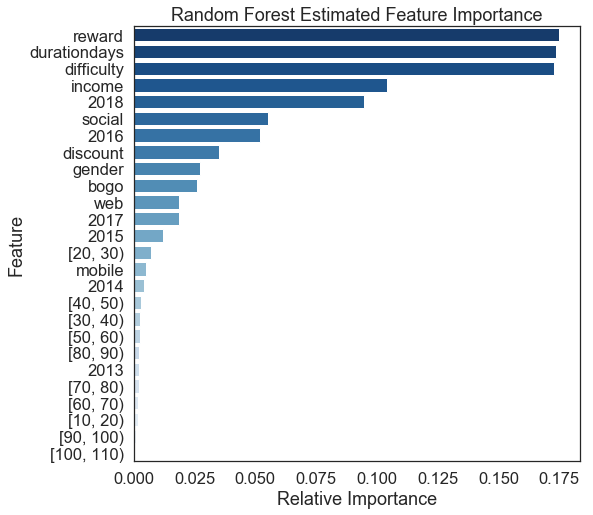

In [51]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

**Observation:** the top five features are:

    1. Offer reward
    2. Offer duration
    3. Offer difficulty (how much money a customer must spend to complete an offer)
    4. Customer income
    5. Whether a customer created an account on the Starbucks rewards mobile application in 2018


In [52]:
#  top 10 features sorted based on their estimated importance
feature_importance.head(n=10)

,feature,relativeimportance
0,reward,0.174812
1,durationdays,0.173591
2,difficulty,0.172752
3,income,0.104085
4,2018,0.094520
5,social,0.055022
6,2016,0.051985
7,discount,0.035106
8,gender,0.027115
9,bogo,0.025888


## Gradient Boosting classifier

In [53]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    gb_random = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    gb_random.fit(X_train, y_train)

    dump(gb_random, gb_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=  11.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=  11.3s
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=  11.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.001 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, loss=expon

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   0.5s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   0.5s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   0.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.8s
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.9s
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.8s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=5, min_samples_

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.5s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.5s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.5s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=   7.2s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=   7.3s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=   7.3s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  11.4s
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  11.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  11.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=  16.6s
[CV] n_estimat

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   2.0s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001 
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001 


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.3min
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   2.2s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   3.0s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   3.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   2.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=  20.1s
[CV] n_est

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.6s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.6s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   1.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=  14.0s
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=  14.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.1 
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=  14.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=   0.5s
[CV]  n_estimators=10, 

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   7.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   7.7s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   7.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=  13.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=  13.2s
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=  13.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=  11.2s
[CV]  n_estimators=2

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.6s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.6s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   0.6s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.6s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=  11.3s
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=  11.3s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=  11.3s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   8.2s
[CV] n_estimators=3

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=   0.8s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=   0.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01 
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=   0.8s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01, total=   8.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01, total=   8.4s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.01, total=   8.3s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=  14.4s
[CV

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.3min


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.4s
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.4s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.1, total=  11.4s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.1, total=  18.5s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.1, total=  18.6s
[CV] n_estimators=200, min_samples_spl

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.7s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   5.9s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   5.9s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   5.9s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   2.0s
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   2.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=30, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   2.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=  11.7s
[CV]  n_estimator

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   6.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   6.9s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   7.0s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.8s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.8s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.7s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   2.1s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   2.1s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   2.1s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   9.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   9.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=4, loss=deviance, learning_rate=0.01, total=   9.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, loss=exponential, learning_rate=0.1, total=   3.2s
[CV] n_estimators=30, min

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   1.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   1.9s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=   1.9s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1, total=  14.4s
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1, total=  14.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.1, total=  14.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=   3.2s
[CV]  n_estimators=50, min_

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   0.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   0.8s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01 
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   0.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  18.9s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  19.0s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.01, total=  19.0s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=   9.2s
[CV]  n_estimat

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   1.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   1.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   1.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   6.1s
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   6.1s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   6.2s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=  17.7s
[CV] n_estimato

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.001, total=   5.9s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=  17.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=  17.6s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, loss=deviance, learning_rate=0.1, total=  17.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, loss=deviance, learning_rate=0.1, total=   3.3s
[CV] n_estimators=100, min_samples_split=2

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   5.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   6.0s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, loss=deviance, learning_rate=0.001, total=   6.0s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   1.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   1.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   2.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, loss=exponential, learning_rate=0.01, total=   6.3s
[CV] n_es

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 13.8min finished


In [54]:
# Evaluate Gradient Boosting Model Performance
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)

GradientBoostingClassifier model accuracy: 0.735
GradientBoostingClassifier model f1-score: 0.725


(0.735324388198521, 0.7252982018871283)

# Fine-Tune the best model

Bias and variance are two characteristics of a machine learning model. Bias refers to inherent model assumptions regarding the decision boundary between different classes. On the other hand, variance refers a model's sensitivity to changes in its inputs. A logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers. However, my exploratory analysis of customer demographics for each offer suggests that this decision boundary will be non-linear. Therefore, an ensemble method like random forest or gradient boosting should perform better.

In [55]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest',
                   'gradientboosting']

model_performance.append((naive_predictor_accuracy,
                          naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(gb_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.716
RandomForestClassifier model accuracy: 0.741
RandomForestClassifier model f1-score: 0.736
GradientBoostingClassifier model accuracy: 0.735
GradientBoostingClassifier model f1-score: 0.725


,classifiertype,accuracy,f1score
0,randomforest,0.741481,0.736109
1,gradientboosting,0.735324,0.725298
2,logisticregression,0.721526,0.716308
3,naivepredictor,0.471659,0.640989


In [56]:
# Print the Best Model's Hyperparameters
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=2310, verbose=0,
            warm_start=False)


### Refine Best Model

In [57]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split,
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.8s
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.8s
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=10

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.8min


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  12.1s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.9s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310, total=  14.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.4s
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=   8.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310 
[CV] max_depth=10, min_samples_leaf=2, min_samples_

[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310, total=  12.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310, total=  12.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310, total=  12.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_esti

[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310, total=   9.3s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310, total=  11.2s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  13.3s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 12.3min


[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  13.2s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  10.7s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  16.0s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  16.0s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310, total=  21.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_s

[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  14.0s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  13.7s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  14.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  14.2s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=10, n_

[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310, total=  12.6s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310, total=  12.8s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310, total=  12.8s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310, total=  12.6s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_esti

[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310, total=  16.2s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.6s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.8s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.9s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.8s
[CV] max_depth=11, min_samples_leaf=1, min_s

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  15.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  16.9s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310, total=  18.4s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310, total=  15.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310, total=  14.5s
[CV] max_depth=11, min_samples_leaf=2, min_samples_s

[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=   8.9s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310, total=  10.5s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310, total=  10.6s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 29.3min


[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310, total=  10.5s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310, total=  12.2s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310, total=  12.3s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310, total=  12.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=2310, total=  11.7s
[CV] max_depth=11, min_samples_leaf=2, min_

[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310, total=   9.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=2310, total=  15.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310, total=   8.7s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=2310, total=   8.6s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_esti

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=2310, total=  11.5s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=2310, total=  11.3s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310, total=  13.5s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310, total=  13.4s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=2310, total=  12.7s
[CV] max_depth=11, min_samples_leaf=4, min_

[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=2310, total=   7.7s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=2310, total=   7.6s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310, total=   9.0s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310, total=   9.0s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_esti

[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=2310, total=  14.2s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=2310, total=  14.3s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=2310, total=  17.1s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310, total=  20.6s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=2310, total=  21.1s
[CV] max_depth=12, min_samples_leaf=1, min_

[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  17.3s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  19.2s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  19.5s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310, total=  20.6s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_esti

[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  23.7s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  28.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  24.2s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  21.5s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=2, 

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  14.5s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  14.6s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  14.7s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  13.6s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  13.4s
[CV] max_depth=12, min_samples_leaf=4, min_samples_s

[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 57.8min


[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310, total=  19.4s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310, total=  20.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310, total=  18.2s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  18.7s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  18.6s
[CV] max_depth=12, min_samples_leaf=4, min_samples_s

[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310, total=  13.4s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310, total=  13.4s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310, total=  13.1s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310, total=  12.8s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=2310, total=  14.8s
[CV] max_depth=13, min_samples_leaf=1, min_samples_s

[CV] max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310, total=  20.0s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310, total=  19.8s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310, total=  19.5s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310, total=  19.2s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=10, n_

[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  19.9s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  21.5s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  22.2s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=2310, total=  18.8s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_esti

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=  12.5s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310, total=  20.4s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=  12.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=  12.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=2310, total=  12.2s
[CV] max_depth=13, min_samples_leaf=2, min_s

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310, total=  14.9s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310, total=  15.5s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310, total=  18.3s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310, total=  20.0s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=2310, total=  19.3s
[CV] max_depth=13, min_samples_leaf=4, min_samples_s

[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310, total=  12.5s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310, total=  11.0s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310, total=  12.8s
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310, total=  12.9s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310 
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=

[CV] max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310, total=  19.5s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310, total=  21.4s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=2310, total=  21.5s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2310, total=  24.0s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_esti

[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310, total=  14.8s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310, total=  13.5s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310, total=  13.2s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=2310, total=  13.2s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=2310, total=  15.2s
[CV] max_depth=14, min_samples_leaf=1, min_

[CV] max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=2310, total=  18.4s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=2310, total=  18.2s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=2310, total=  18.4s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=2310, total=  11.0s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=2, n_esti

[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 97.8min


[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  12.4s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  12.8s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=2310, total=  12.8s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310, total=  15.0s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=2310, total=  14.7s
[CV] max_depth=14, min_samples_leaf=2, min_samples_s

[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  18.1s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  17.7s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  17.6s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=2310, total=  17.8s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=2310, total=  10.3s
[CV] max_depth=14, min_samples_leaf=4, min_samp

[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  13.1s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  13.2s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  11.9s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=2310, total=  12.8s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_esti

[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=  12.6s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=  11.9s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=  11.5s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=2310, total=  11.7s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_esti

[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2310, total=  16.7s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310, total=  18.6s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310, total=  18.7s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310, total=  19.0s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=2310, total=  19.0s
[CV] max_depth=15, min_samples_leaf=1, min_samples_s

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=  10.3s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=2310, total=  10.1s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310, total=  11.9s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310, total=  11.7s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=2310, total=  11.7s
[CV] max_depth=15, min_samples_leaf=2, min_samples_s

[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310, total=  15.4s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=2310, total=  15.2s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310, total=  17.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310, total=  17.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_esti

[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  11.1s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  10.9s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=2310, total=  11.2s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310, total=  12.7s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_esti

[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  15.8s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  15.5s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  15.8s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310, total=   9.3s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=2310 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=2310, total=  15.8s
[CV] max_depth=15, min_samples_leaf=4, min_sampl

[Parallel(n_jobs=3)]: Done 1350 out of 1350 | elapsed: 131.9min finished


RandomForestClassifier model accuracy: 0.768
RandomForestClassifier model f1-score: 0.760


(0.7677060303423039, 0.7598612917208496)

In [58]:
# Print the Refined Random Forest Model's Hyperparameters
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
            oob_score=False, random_state=2310, verbose=0,
            warm_start=False)

In [59]:
# Evaluate Test Data Performance
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.734
RandomForestClassifier model f1-score: 0.723


(0.7343142486849127, 0.7225981055480377)

# Conclusion
The problem was to build a model that predicts whether a customer will respond to an offer.  The analysis suggests that a random forest model has the best training data accuracy and F1-score.  The resulting random forest model has an training data accuracy of 0.768 and an F1-score of 0.760. The test data set accuracy of 0.734 and F1-score of 0.723 suggests that the random forest model did not overfit the training data.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. Analysis of the training data suggests that the top five features based on their importance are:

1. Offer reward
2. Offer duration   
3. Offer difficulty (how much money a customer must spend to complete an offer)  
4. Customer income  
5. Whether a customer created an account on the Starbucks rewards mobile application in 2018  

Since the top three features are associated with an customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.